In [48]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os


In [49]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoMotive_data_001', 'engine_CIM001_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


119
C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoMotive_data_001\engine_CIM001_result


In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [51]:


# CSVファイルの読み込み
file_path =os.path.join(onedrive_path,'CODES','samples','engine_data.csv')
data = pd.read_csv(file_path)

# データの前処理
data = data.dropna()  # 欠損値を削除

# 特徴量とターゲットに分ける
# 'Engine Condition' をターゲット変数として仮定
X = data.drop(columns=['Engine Condition'])
y = data['Engine Condition']

# 特徴量を標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#平均と標準偏差を使ってデータをスケーリング

# データセットを分割（train, test）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# NumPy配列をPyTorchのTensorに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # 分類用ラベル
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# TensorDatasetを作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaderを作成（バッチ処理用）
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 動作確認
for batch_X, batch_y in train_dataloader:
    print("Batch X Shape:", batch_X.shape)
    print("Batch y Shape:", batch_y.shape)
    break


Batch X Shape: torch.Size([32, 6])
Batch y Shape: torch.Size([32])


In [52]:
class Encoder(nn.Module):#CIM
    def __init__(self, input_dim, leverage, alpha=1.2):
        super(Encoder, self).__init__()
        self.leverage = leverage
        self.alpha = alpha

        output_dim = input_dim // leverage

        phase = torch.rand(output_dim, input_dim) * 2 * np.pi - np.pi
        modulus = torch.rand(output_dim, input_dim)

        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = True

    def forward(self, x):
        x = 1+torch.exp(1j * self.alpha * x)
        x = torch.matmul(self.B, x.T).T
        x = torch.abs(x)**2
        return x

In [53]:
class PreBlock(nn.Module):

    def __init__(self, in_dim, out_dim, use_ln):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.relu = nn.LeakyReLU(inplace=True)
        self.use_ln = use_ln
        if use_ln:
            self.ln = nn.LayerNorm(out_dim)

    def forward(self, x):
        x = self.fc(x)       # (B, out_dim)
        if self.use_ln:
            x = self.ln(x)
        x = self.relu(x)
        return x

In [54]:
class Decoder(nn.Module):
    def __init__(self, num_in, num_out):
        super(Decoder, self).__init__()

        #self.pre = nn.Sequential(nn.Linear(num_in, num_in),nn.LayerNorm(num_in),nn.ReLU())
        self.decoder_fc1 = nn.Linear(num_in, int((num_in + num_out) / 2))
        self.a1 = nn.Tanh()
        self.decoder_fc2 = nn.Linear(int((num_in + num_out) / 2), num_out)
        #self.a2 = nn.ReLU()

    def forward(self, x):
        #x = self.pre(x)
        x = self.decoder_fc1(x)
        x = self.a1(x)
        x = self.decoder_fc2(x)
        #x = self.a2(x)
        return x

In [55]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, leverage):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_dim, leverage)
        self.decoder = Decoder(int(input_dim / leverage), input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x_reconstructed = self.decoder(x)
        return x_reconstructed

In [56]:

def TableCreater(batch_X, scaler, columns):

    # 有効数字の定義
    significant_digits = {
        'Engine rpm': 5,
        'Lub oil pressure': 8,
        'Fuel pressure': 8,
        'Coolant pressure': 8,
        'lub oil temp': 7,
        'Coolant temp': 7
    }

    # 有効数字を適用する関数
    def apply_significant_digits(value, digits):
        if value == 0:
            return 0
        else:
            return round(value, digits - int(np.floor(np.log10(abs(value)))) - 1)

    # スケールを元に戻す
    X_original = batch_X.numpy() * scaler.scale_ + scaler.mean_
    restored_df = pd.DataFrame(X_original, columns=columns)

    # 各特徴量に有効数字を適用
    for column, digits in significant_digits.items():
        if column in restored_df.columns:
            restored_df[column] = restored_df[column].apply(apply_significant_digits, args=(digits,))

    return restored_df.head(5).to_csv(sep='\t', index=False) # 最初の5行を返す


In [57]:
def plot_histograms(all_X, scaler, columns):

    # バッチデータを1つの配列に結合
    all_X_combined = np.vstack(all_X)

    # 標準化を元に戻す
    all_original_X = all_X_combined * scaler.scale_ + scaler.mean_

    # ヒストグラムを特徴量ごとに作成
    num_features = len(columns)  # 特徴量の数
    rows = (num_features + 2) // 3  # 3列2行で表示するための行数計算
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

    # 各特徴量のヒストグラムをプロット
    for i, column in enumerate(columns):  # columns は特徴量名を使用
        row, col = divmod(i, 3)
        ax = axes[row, col]
        ax.hist(all_original_X[:, i], bins=20, edgecolor='k', alpha=0.7)
        ax.set_title(f'Histogram of {column}',fontsize=18)
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.grid(True, linestyle='--', alpha=0.5)

    # 空白のプロットを削除
    for j in range(num_features, rows * 3):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

In [58]:
for batch_X, batch_y in test_dataloader:
    processed_df = TableCreater(batch_X, scaler, data.columns.drop('Engine Condition'))
    break

# 結果の表示
print(processed_df)

Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
682.0	2.3916559	4.6171958	2.8489821	76.27242	69.88461
605.0	5.4668769	6.4243607	5.7275201	73.22268	74.90731
658.0	3.4342322	3.6808963	1.6787082	88.08992	78.70481
749.0	2.0946565	7.120927	1.6396704	77.66163	82.3867
676.0	3.538228	5.9564724	3.2253363	75.22635	67.15322



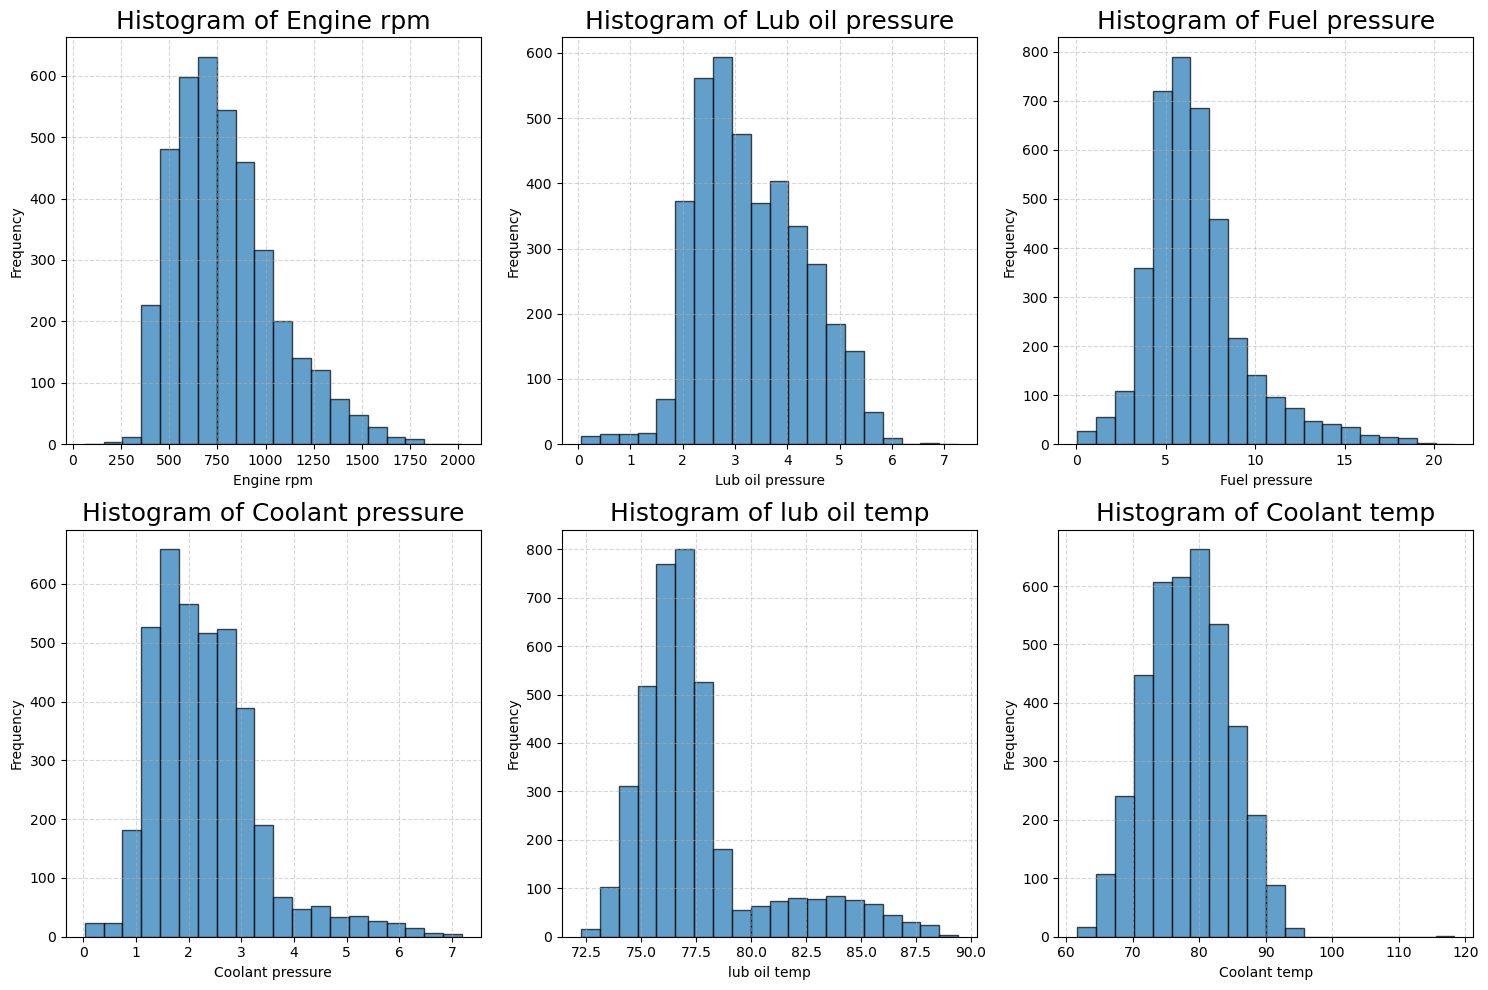

In [59]:
all_X = []
for batch_X, _ in test_dataloader:
    all_X.append(batch_X.numpy())

plot_histograms(all_X, scaler, data.columns.drop('Engine Condition'))

1/5th Time Epoch: 20/20

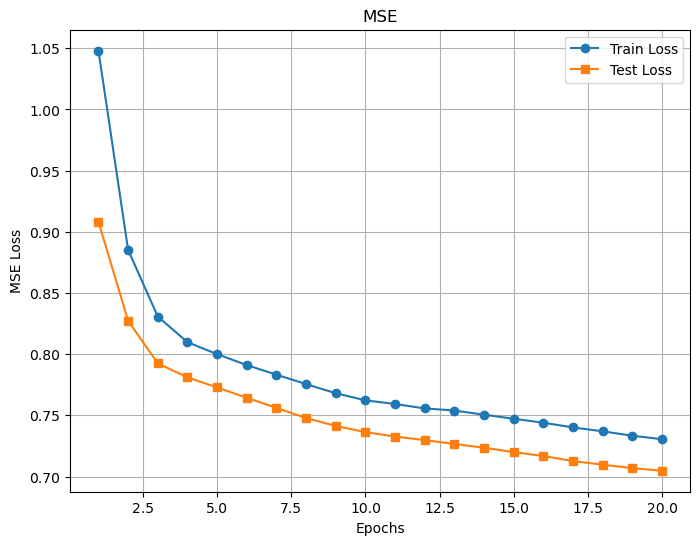

MSE 0.7047228200164267
Time 26.697174310684204
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
820.53	2.8432668	5.4986567	2.4344168	80.21205	78.82143
734.92	4.1692817	9.7191486	2.0337157	76.37575	78.55995
855.68	4.0784082	5.5146472	1.9231794	77.92262	79.02742
774.25	2.8215851	6.1754532	2.1817779	76.50189	79.46713
750.86	3.9921627	5.3793561	2.1813206	79.383	77.95137



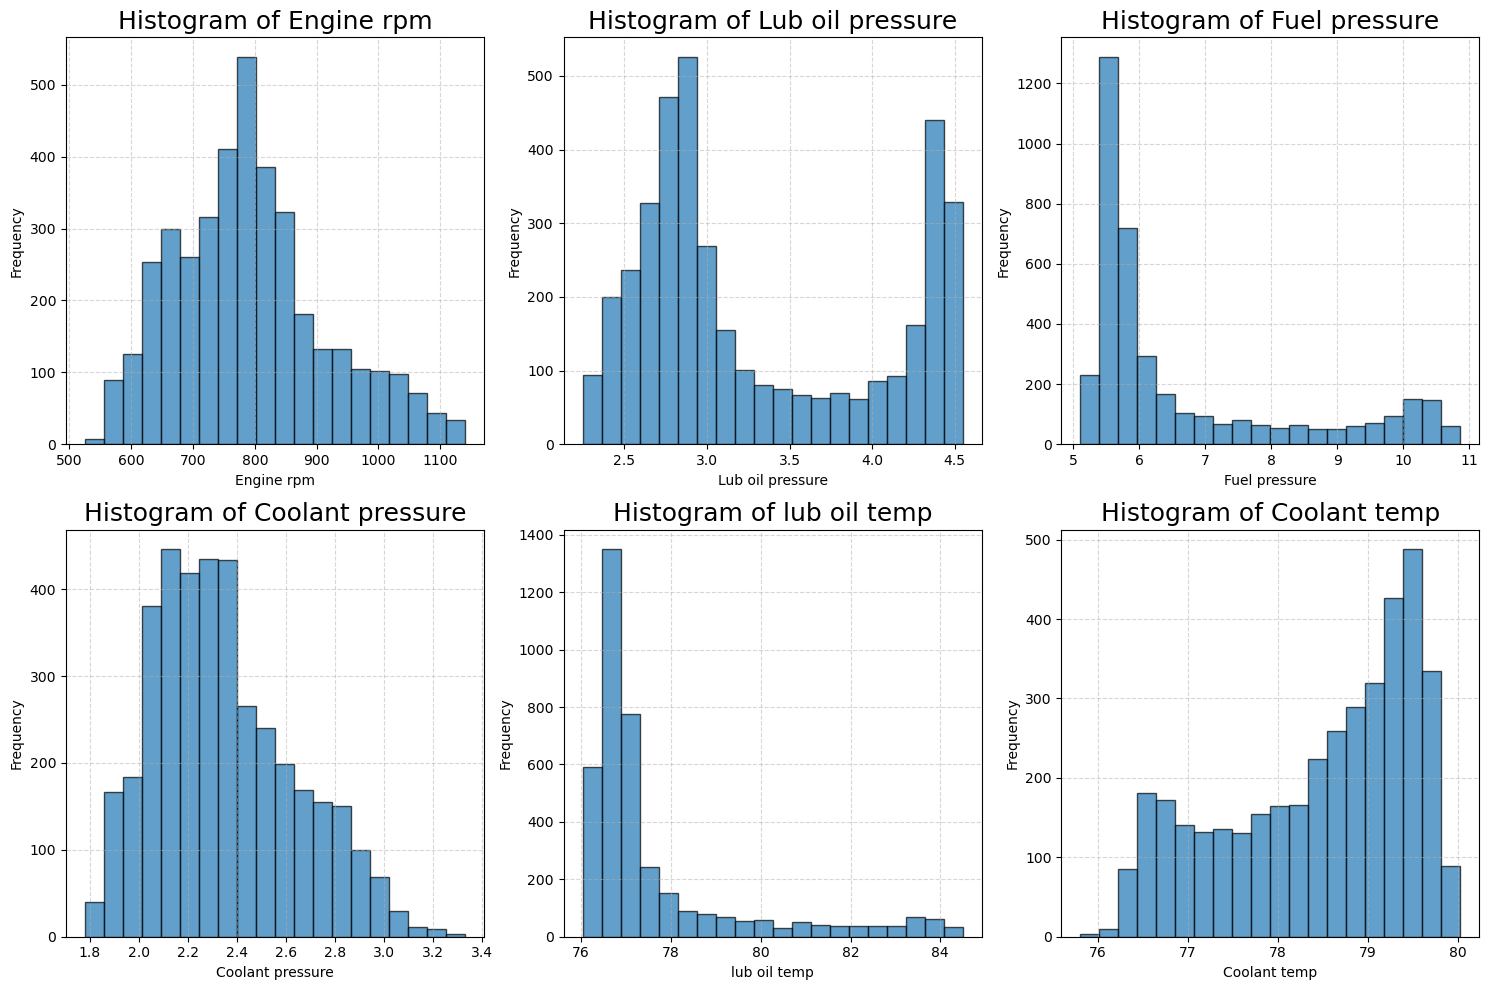

2/5th Time Epoch: 20/20

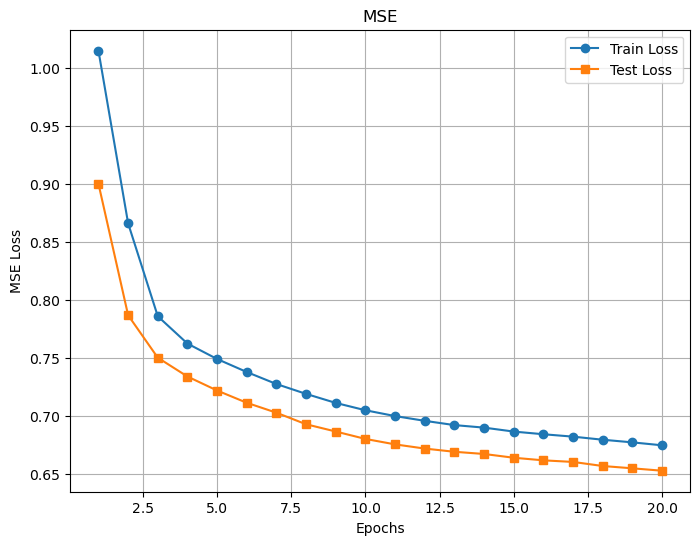

MSE 0.653096214542544
Time 30.737759113311768
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
874.87	2.7449397	6.7804215	2.8580608	76.73712	71.88528
660.57	4.0309196	7.5523135	2.6384542	77.22909	79.03692
942.63	3.821639	6.8519561	1.9691445	76.98078	82.95089
787.14	2.4660303	5.8591865	2.0260656	78.02019	84.42126
757.15	3.6146663	7.6465985	3.3729416	75.94514	71.43506



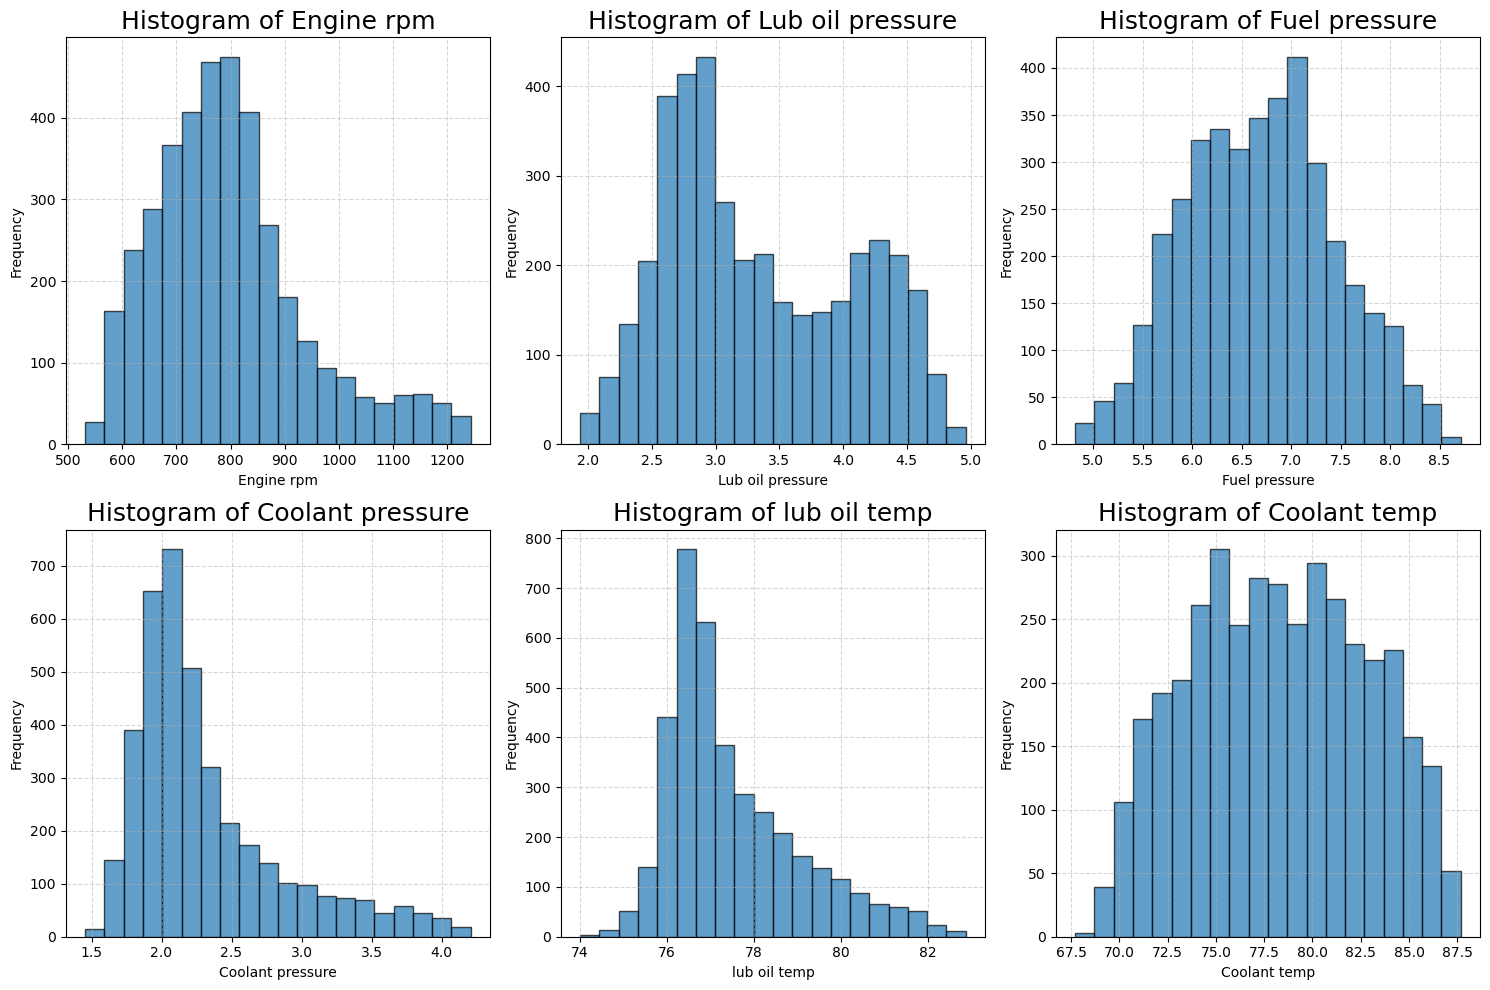

3/5th Time Epoch: 20/20

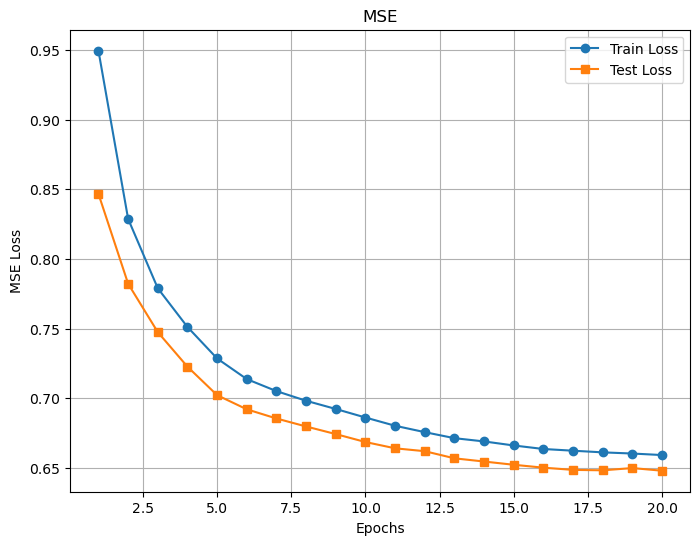

MSE 0.6480164983408238
Time 27.872128009796143
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
688.64	2.6454307	6.8925582	2.9476177	74.85674	77.30431
1007.4	4.6198808	7.6365619	2.3637815	76.94641	72.40202
699.3	3.9484515	5.4716125	1.8556985	80.86359	81.93724
831.77	2.469931	5.9602974	2.3068821	76.72475	81.79527
652.14	3.3339395	7.9749828	2.9868148	75.70917	73.1561



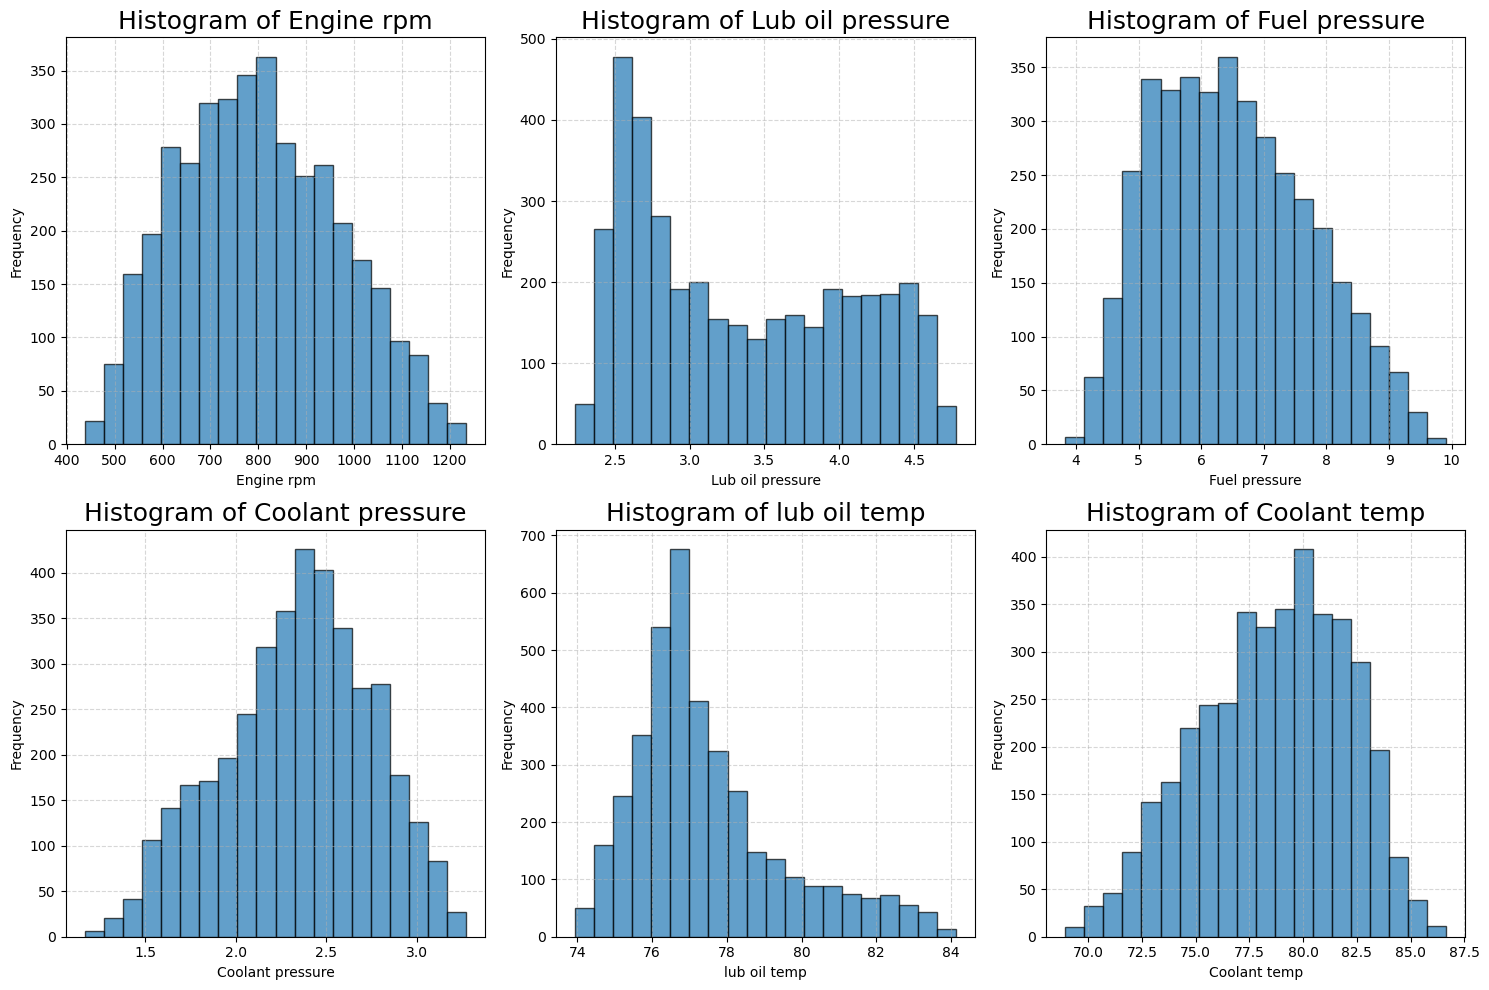

4/5th Time Epoch: 20/20

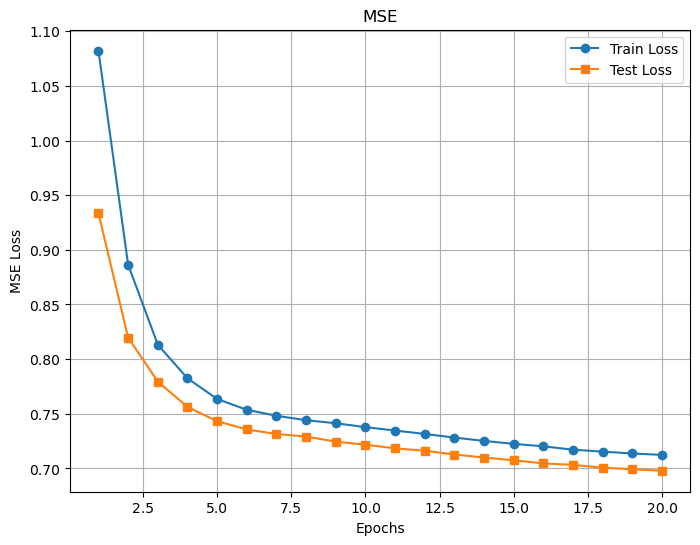

MSE 0.6978671478062142
Time 26.539647340774536
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
640.62	3.2286214	5.167641	2.6910385	76.05045	76.75393
685.06	4.043625	7.3222381	2.2368853	77.26611	69.74743
906.19	3.5436052	5.2547278	2.2342335	81.97869	83.18353
653.96	2.8444694	6.8090164	2.4939201	76.18431	80.1745
535.83	3.6354882	5.7712511	2.6072716	76.15451	72.9476



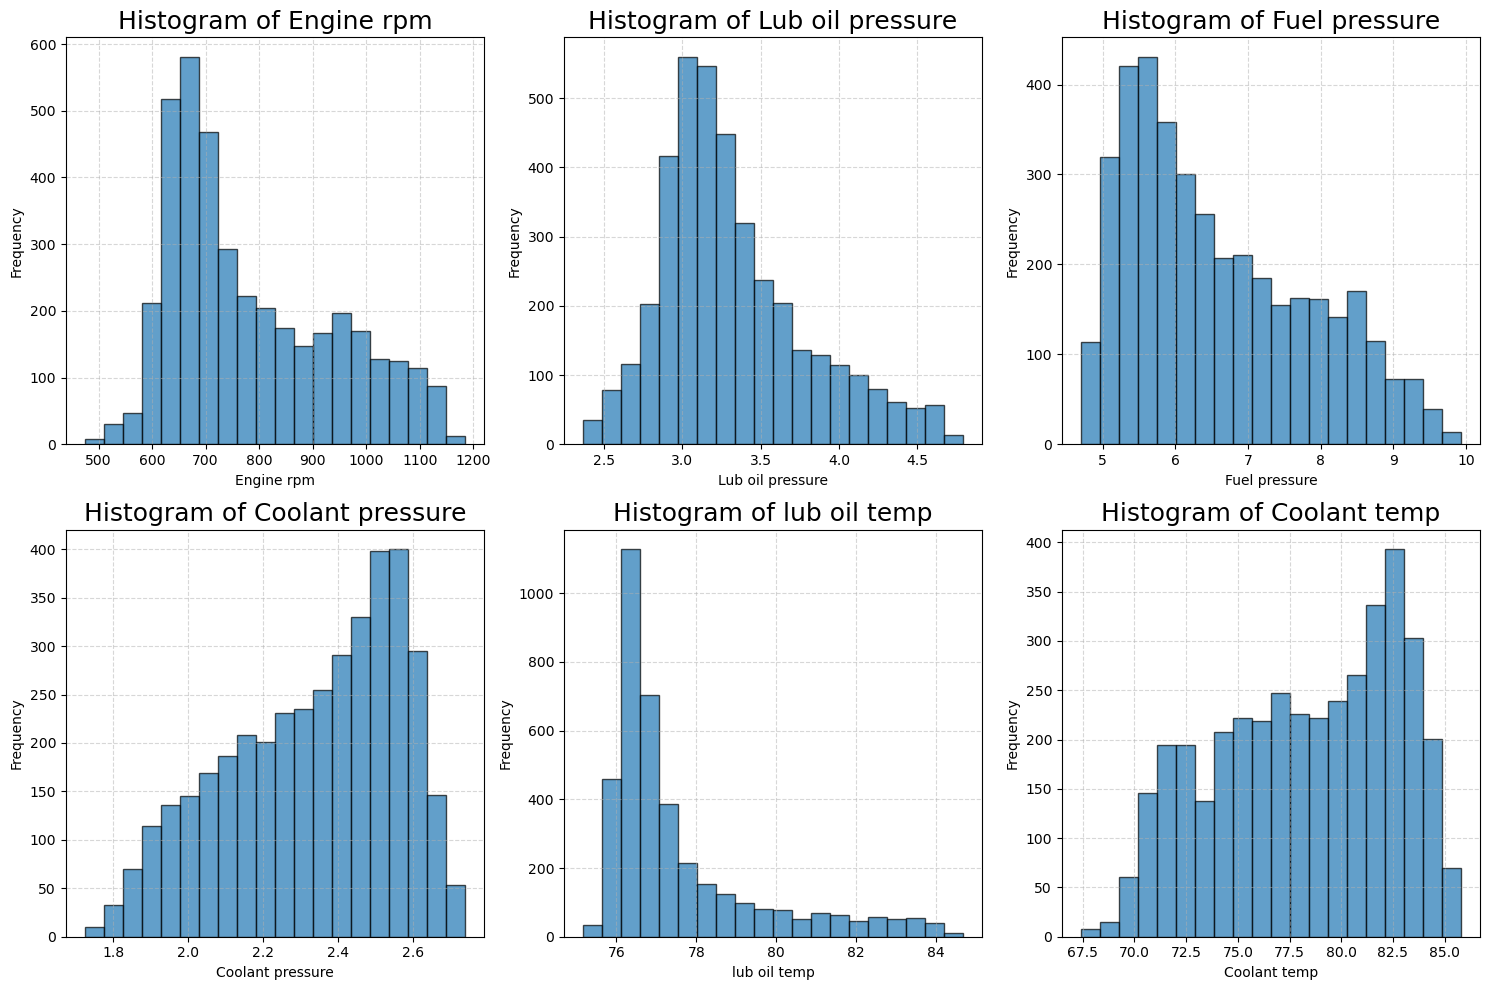

5/5th Time Epoch: 20/20

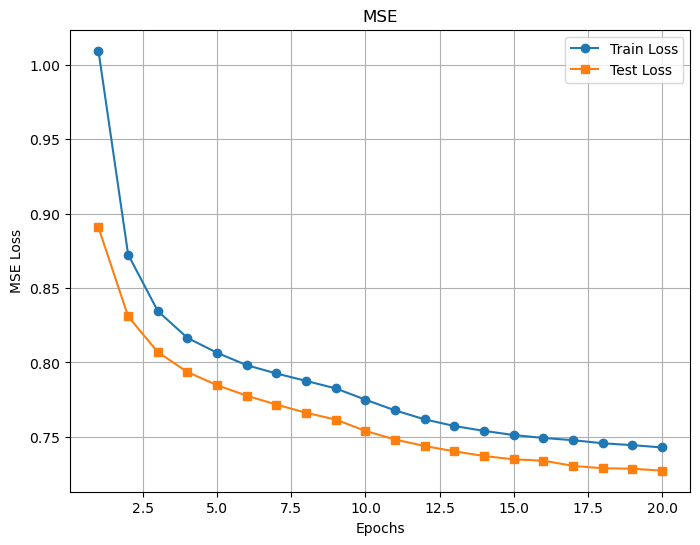

MSE 0.7273322111222802
Time 29.11724328994751
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
664.69	3.0598318	5.6242338	2.5916698	79.20027	78.33763
667.13	3.5043056	9.114811	2.1753201	76.1363	78.2354
930.22	3.7031411	5.7694294	2.0062828	79.85254	76.35686
655.31	3.2940913	6.6428436	2.2821698	76.51121	78.45361
649.56	3.1531385	6.4480772	2.6082182	77.53521	76.19155



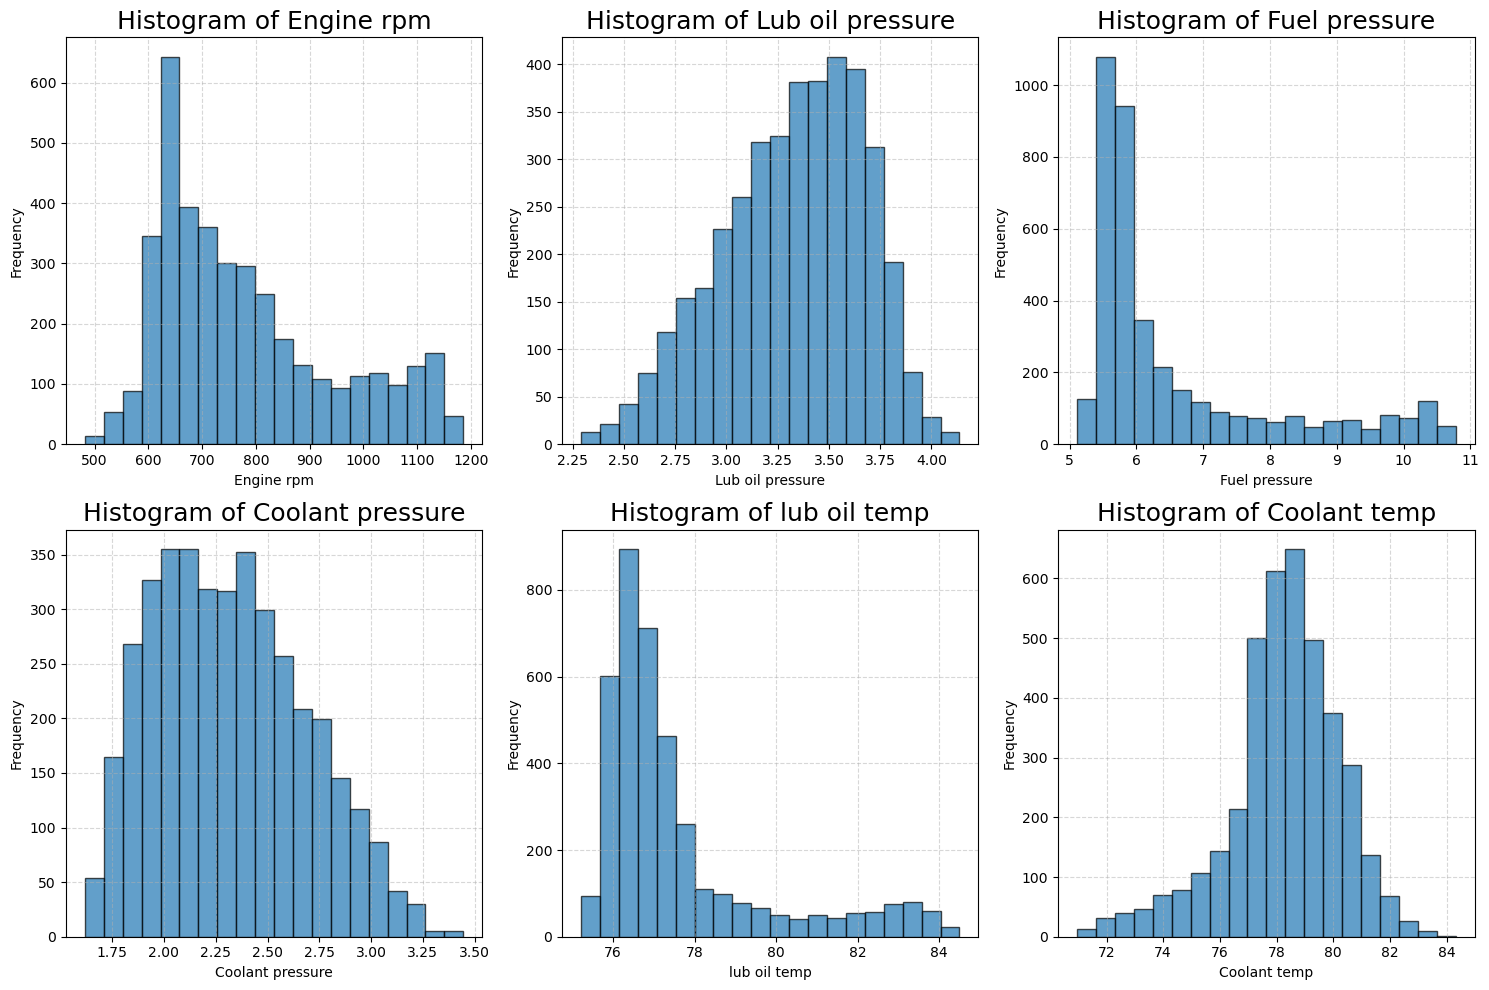

In [60]:
input_dim = X_train.shape[1]
leverage = 1  # 圧縮倍率
max_epochs = 20
lr = 0.0005 #学習率

num_try = 5 #

All_last_loss = []
All_loss_test = []
All_pro_time = []

for num_times in range(num_try): 
    model = AutoEncoder(input_dim, leverage).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

    for epoch in range(max_epochs):
        model.train()
        epoch_loss_train = 0
        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()

        start_time1 = time.time()
        for batch_X, _ in train_dataloader:
            batch_X = batch_X.to(device)

            reconstructed = model(batch_X)
            loss = criterion(reconstructed, batch_X)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

        epoch_loss_train /= len(train_dataloader)
        loss_train_.append(epoch_loss_train)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)

        # テスト損失計算
        model.eval()
        epoch_loss_test = 0
        with torch.no_grad():
            for batch_X, _ in test_dataloader:
                batch_X = batch_X.to(device)
                reconstructed = model(batch_X)
                loss = criterion(reconstructed, batch_X)
                epoch_loss_test += loss.item()

        epoch_loss_test /= len(test_dataloader)
        loss_test_.append(epoch_loss_test)

        if epoch == max_epochs-1:
            All_loss_test.append(loss_test_)
            All_pro_time.append(sum(pro_time_)) 
            Last_loss_test = loss_test_[-1]
            All_last_loss.append(Last_loss_test)

    # 収束グラフ
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_epochs+1), loss_train_, label='Train Loss', marker='o')
    plt.plot(range(1, max_epochs+1), loss_test_, label='Test Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('MSE',epoch_loss_test)
    print('Time',sum(pro_time_))

    all_test_X = []
    with torch.no_grad():  # 勾配計算を無効化
        for batch_X, _ in test_dataloader:
            batch_X = batch_X.to(device)
            reconstructed = model(batch_X).cpu().detach()  # モデルに通して復元
            all_test_X.append(reconstructed.numpy())

    with torch.no_grad():  # 勾配計算を無効化
        for batch_X, _ in test_dataloader:
            batch_X = batch_X.to(device)
            reconstructed = model(batch_X).cpu().detach()  # モデルに通して復元
            processed_df = TableCreater(reconstructed, scaler, data.columns.drop('Engine Condition'))
            print(processed_df)
            break

    plot_histograms(all_test_X, scaler, data.columns.drop('Engine Condition'))

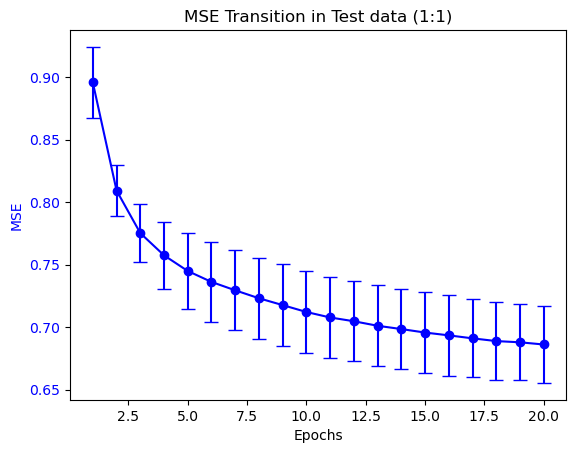

In [61]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('MSE Transition in Test data (1:%d)' % leverage)
file_name = '%d_MSE_errorbar.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

plt.show()

In [62]:

MSE_mean = np.mean(All_last_loss)
MSE_best = np.min(All_last_loss)
MSE_bestID = np.argmin(All_last_loss)+1
MSE_worst = np.max(All_last_loss)
MSE_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["MSE"],
    "Average": [MSE_mean],
    "Best ID": [MSE_bestID],
    "Best": [MSE_best],
    "Worst ID": [MSE_worstID],
    "Worst": [MSE_worst],
}

df = pd.DataFrame(data)

print(df)


         Average  Best ID      Best  Worst ID     Worst
0  MSE  0.686207        3  0.648016         5  0.727332


In [63]:
pro_time_mean = sum(All_pro_time)/len(All_pro_time)
data2 = {
    "Index": list(range(1, len(All_pro_time) + 1)),  # インデックス（1から開始）
    "Processing Time": All_pro_time                # 各処理時間
}

df2 = pd.DataFrame(data2)
df2.loc[""] = ["Average", pro_time_mean]

print(df2)

     Index  Processing Time
0        1        26.697174
1        2        30.737759
2        3        27.872128
3        4        26.539647
4        5        29.117243
   Average        28.192790


In [64]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoMotive_data_001','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'engine_CIM001_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoMotive_data_001\texts
